In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal
import cartopy.crs as ccrs
import cmaps
import cartopy.feature as cf
import cmocean

In [115]:
mask = xr.open_dataset('data/REFORECASTS_MASKS.nc').coastmask_south
mask

<xarray.DataArray 'coastmask_south' (lat: 81, lon: 71)>
[5751 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 220.0 221.0 222.0 223.0 ... 287.0 288.0 289.0 290.0
  * lat      (lat) float32 -40.0 -39.0 -38.0 -37.0 -36.0 ... 37.0 38.0 39.0 40.0

In [76]:
ERA5winds      = xr.open_dataset('data/COQUIMBO_VIENTO/HOVMOLLER/ERA5_COASTWINDS.nc').convert_calendar('noleap')
ERA5winds_clim = xr.open_dataset('data/COQUIMBO_VIENTO/HOVMOLLER/ERA5_COASTWINDS_clim.nc')

S2Swinds       = xr.open_dataset('data/COQUIMBO_VIENTO/HOVMOLLER/reforecast_winds_coastsouth.nc')
S2Swinds       = S2Swinds.rename({'inittime':'time'}).convert_calendar('noleap').drop_duplicates('time').interp({'time':ERA5winds.time.values})
S2Swinds_clim  = xr.open_dataset('data/COQUIMBO_VIENTO/HOVMOLLER/reforecast_winds_coastsouth_clim.nc')


reference = (ERA5winds.groupby('time.dayofyear')-ERA5winds_clim).ws.sel(time=slice('2000','2020')).rename({'latitude':'lat'}).to_dataset(name='ws')
forecast  = (S2Swinds.groupby('time.dayofyear')-S2Swinds_clim).ws.sel(time=slice('2000','2020')).rename({'time':'inittime'}).to_dataset(name='ws').dropna('inittime')


In [85]:
zones_south = {'Paita':slice(-6,-3),
               'Pisco':slice(-16,-12),
               'Coquimbo':slice(-32,-28)}

zsouth_forecast  = {keys:forecast.sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}
zsouth_reference = {keys:reference.sel(lat=zones_south[keys]).mean('lat') for keys in zones_south.keys()}

In [102]:
zsouth_rmse = {keys:None for keys in zones_south.keys()}
for z in list(zones_south.keys()):
    print(z,'\n')
    reforecast = zsouth_forecast[z]
    era5       = zsouth_reference[z]
    skill = []
    for lead in reforecast.leadtime.values:
        if lead%6==1:
            print('lead',lead)
        x = reforecast.sel(leadtime=lead).drop_duplicates('inittime')
        x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
        x = x.swap_dims({'inittime':'time'})
        x = x.interp(time=era5.time.values).dropna('time')
        x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
        y = era5.sel(time=x.time.values)
        x = x.groupby('inittime.dayofyear')
        skilldayofyear = []
        for i in range(1,365+1):
            c = []
            for v in x[i].keys():
                c.append(((x[i][v]-y[v].reindex({'time':x[i][v].time.values}))**2).mean('time')**0.5)
            skilldayofyear.append(xr.merge(c))
        skill.append(xr.concat(skilldayofyear, 'dayofyear'))
    skill = xr.concat(skill,'leadtime')
    zsouth_rmse[z] = skill.copy()

Paita 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
Pisco 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
Coquimbo 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43


<xarray.Dataset>
Dimensions:    (time: 7660)
Coordinates:
    leadtime   int64 0
    height     (time) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
  * time       (time) object 2000-01-06 00:00:00 ... 2020-12-31 00:00:00
    dayofyear  (time) int64 6 7 8 9 10 11 12 13 ... 359 360 361 362 363 364 365
Data variables:
    ws         (time) float64 -0.1469 1.397 2.941 4.484 ... -1.937 3.006 1.946

<xarray.Dataset>
Dimensions:   (leadtime: 47, dayofyear: 365)
Coordinates:
  * leadtime  (leadtime) int64 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45 46
Dimensions without coordinates: dayofyear
Data variables:
    ws        (leadtime, dayofyear) float64 1.0 1.0 1.0 ... 0.3574 0.3387 0.2854

In [176]:
zsouth_skill = {keys:None for keys in zones_south.keys()}
for z in list(zones_south.keys()):
    print(z,'\n')
    reforecast = zsouth_forecast[z]
    era5       = zsouth_forecast[z].isel(leadtime=0).rename({'inittime':'time'})#zsouth_reference[z]
    skill = []
    for lead in reforecast.leadtime.values:
        if lead%6==1:
            print('lead',lead)
        x = reforecast.sel(leadtime=lead).drop_duplicates('inittime')
        x.coords['time'] = x.inittime+pd.Timedelta(days=lead)
        x = x.swap_dims({'inittime':'time'})
        x = x.interp(time=era5.time.values).dropna('time')
        x.coords['inittime'] = x.time-pd.Timedelta(days=lead)
        y = era5.sel(time=x.time.values)
        x = x.groupby('inittime.dayofyear')
        skilldayofyear = []
        for i in range(1,365+1):
            c = []
            for v in x[i].keys():
                c.append(xr.corr(x[i][v],y[v],'time'))
            skilldayofyear.append(xr.merge(c))
        skill.append(xr.concat(skilldayofyear, 'dayofyear'))
    skill = xr.concat(skill,'leads').drop('leadtime').assign_coords({'leads':range(47)}).rename({'leads':'leadtime'})
    zsouth_skill[z] = skill.copy()

Paita 



lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
Pisco 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43
Coquimbo 

lead 1
lead 7
lead 13
lead 19
lead 25
lead 31
lead 37
lead 43


Text(0, 0.5, 'WIND SPEED SKILL\n\nleadtime\n(days)')

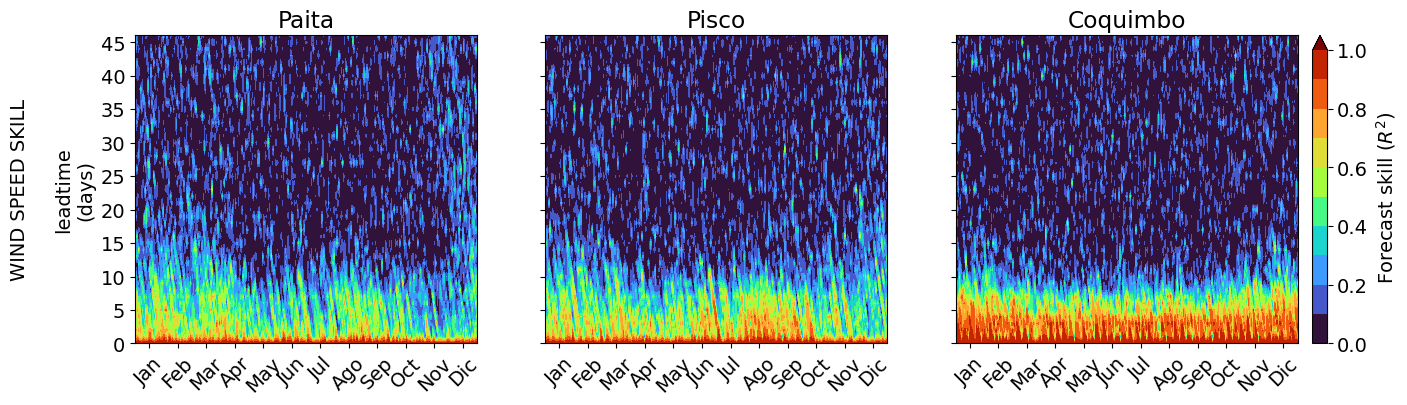

In [177]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, facecolor='w', dpi=100, figsize=(15,4))

plt.rc('font', size=14)
for i,z in enumerate(list(zones_south.keys())):
    x,y = zsouth_skill[z].dayofyear,zsouth_skill[z].leadtime
    X,Y = np.meshgrid(x,y)
    m=(zsouth_skill[z].ws**2).plot.contourf(ax=ax[i], cmap='turbo', levels=np.arange(0,1.1,0.1), add_colorbar=False,)
    # m=(zsouth_skill[z].T300**2).plot.contourf(ax=ax[i], cmap='GnBu', levels=np.arange(0,1.1,0.1), add_colorbar=False)
    
    # mask = (zsouth_skill[z].zos**2>zsouth_skill_persistance[z].zos**2)
    # ax[i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    
    # ax[0,i].pcolor(X,Y,mask.where(mask==1), alpha=0, hatch='...')
   
    # mask = ((zsouth_skill[z].T300**2)>(1.0*zsouth_skill_persistance[z].T300**2))
    # ax[1,i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    
    ax[i].set_xticks(np.linspace(15,349,12))
    ax[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
    ax[i].set_yticks(np.arange(0,46,5))
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(z)
    ax[i].tick_params(axis='x', rotation=45)
    
    
box1 = ax[-1].get_position()
box2 = ax[-1].get_position()
cax  = fig.add_axes([box1.xmax+0.01,box2.ymin,0.01, -box2.ymin+box1.ymax])
fig.colorbar(m, cax=cax, label='Forecast skill ($R^2$)')

ax[0].set_ylabel('WIND SPEED SKILL\n\nleadtime\n(days)')
# ax[1,0].set_ylabel('OCEAN HEAT CONTENT\nANOMALY SKILL\n\nleadtime\n(days)')
# fig.tight_layout()

Text(0, 0.5, 'WIND SPEED ERRORS\n\nleadtime\n(days)')

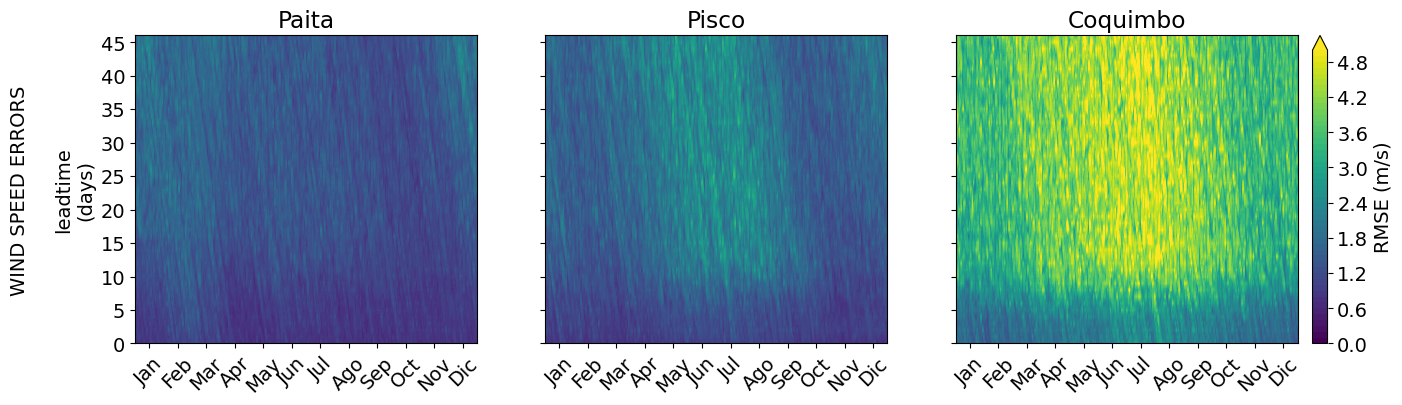

In [108]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, facecolor='w', dpi=100, figsize=(15,4))

plt.rc('font', size=14)
for i,z in enumerate(list(zones_south.keys())):
    x,y = zsouth_skill[z].dayofyear,zsouth_skill[z].leadtime
    X,Y = np.meshgrid(x,y)
    m=(zsouth_rmse[z].ws).plot.contourf(ax=ax[i], cmap='viridis', levels=np.arange(0,5.1,0.1), add_colorbar=False,)
    # m=(zsouth_skill[z].T300**2).plot.contourf(ax=ax[i], cmap='GnBu', levels=np.arange(0,1.1,0.1), add_colorbar=False)
    
    # mask = (zsouth_skill[z].zos**2>zsouth_skill_persistance[z].zos**2)
    # ax[i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    
    # ax[0,i].pcolor(X,Y,mask.where(mask==1), alpha=0, hatch='...')
   
    # mask = ((zsouth_skill[z].T300**2)>(1.0*zsouth_skill_persistance[z].T300**2))
    # ax[1,i].scatter(np.where(mask==1, X, np.nan).ravel(),np.where(mask==1, Y, np.nan).ravel(), s=0.1, marker='X', color='tab:red') #mask.where(mask==0).values.ravel())
    
    ax[i].set_xticks(np.linspace(15,349,12))
    ax[i].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'])
    ax[i].set_yticks(np.arange(0,46,5))
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(z)
    ax[i].tick_params(axis='x', rotation=45)
    
    
box1 = ax[-1].get_position()
box2 = ax[-1].get_position()
cax  = fig.add_axes([box1.xmax+0.01,box2.ymin,0.01, -box2.ymin+box1.ymax])
fig.colorbar(m, cax=cax, label='RMSE (m/s)')

ax[0].set_ylabel('WIND SPEED ERRORS\n\nleadtime\n(days)')
# ax[1,0].set_ylabel('OCEAN HEAT CONTENT\nANOMALY SKILL\n\nleadtime\n(days)')
# fig.tight_layout()

<xarray.DataArray 'ws' (time: 7660)>
array([-0.14691289,  1.39729311,  2.94100487, ..., -1.93740558,
        3.0064821 ,  1.94624094])
Coordinates:
    height     (time) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
  * time       (time) object 2000-01-06 00:00:00 ... 2020-12-31 00:00:00
    dayofyear  (time) int64 6 7 8 9 10 11 12 13 ... 359 360 361 362 363 364 365

In [182]:
zones_leadtimeskill_winds  = {keys:None for keys in zones_south.keys()}
zones_leadtimeRMSE_winds   = {keys:None for keys in zones_south.keys()}


for z in zones_south:
    refer     = zsouth_forecast[z].ws.isel(leadtime=0).drop('leadtime').rename({'inittime':'time'})#zsouth_reference[z].ws#zsouth_reforecast[z].isel(leadtime=0).rename({'inittime':'time'})
    forec     = [zsouth_forecast[z].ws.sel(leadtime=t).shift({'inittime':t}).to_dataset(name='lead{}'.format(t)).drop('leadtime') for t in range(46)]
    forec     = xr.merge(forec).rename({'inittime':'time'})

    allcorr      = forec.map(lambda da: xr.corr(da,refer))
    allcorr      = xr.concat([allcorr[x] for x in allcorr], 'leadtime')
    
    allrmse      = ((forec-refer)**2).mean('time')**0.5
    allrmse      = xr.concat([allrmse[x] for x in allrmse], 'leadtime')
    
    zones_leadtimeskill_winds[z] = {'allcorr':allcorr}
    zones_leadtimeRMSE_winds[z] = {'allcorr':allrmse}
    

/home/lucas/miniconda3/envs/main/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


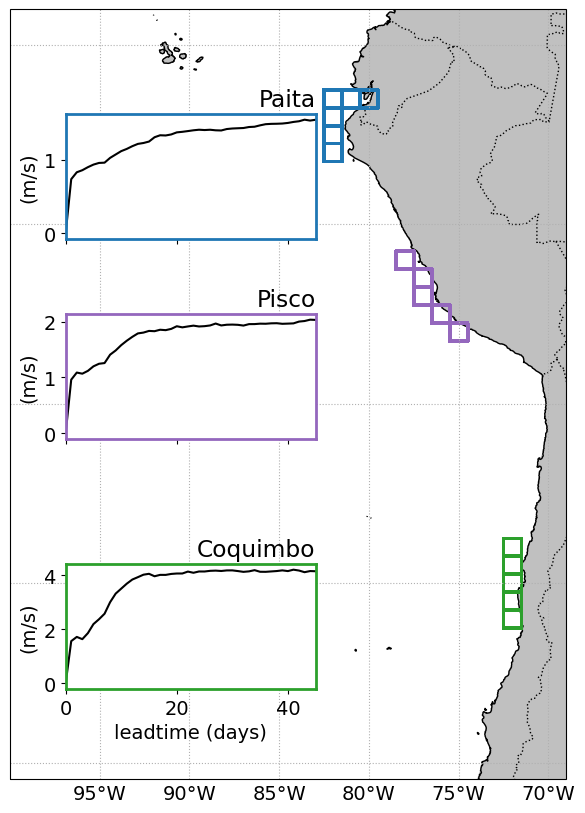

In [190]:
from scipy.stats import linregress
fig, ax = plt.subplots(1,1, facecolor='w', dpi=100, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(10,10))
ax.coastlines('10m')
ax.set_extent([-100,-69,-40,2])
ax.add_feature(cf.LAND, color='silver')
ax.add_feature(cf.BORDERS, color='k', ls=":")
gl=ax.gridlines(draw_labels=True, linestyle=":")
gl.right_labels=False
gl.top_labels=False
gl.left_labels=False
xaxis,yaxis=[0.29,0.29,0.29],[0.65,0.45,0.20]
colors=plt.cm.tab10(np.linspace(0,1,10))[[0,4,2,9],:]
# masks_glorys.tropicalmask.where(masks_glorys.tropicalmask).plot(ax=ax, add_colorbar=False, vmin=0, vmax=1.2, cmap='Reds')
# masks_glorys.coastmask_south.where(masks_glorys.coastmask_south).plot(ax=ax, add_colorbar=False, vmin=0, vmax=1.2, cmap='Reds')
for i,x,y,z in zip(range(3),xaxis,yaxis,zones_south.keys()):
    nax = fig.add_axes([x,y,0.25,0.125])
    data = zones_leadtimeRMSE_winds[z]
    nax.plot(data['allcorr'], color='k', ls="-", label='All S2S forecast (N=7665)')
    # nax.plot(data['low_kw'], color='tab:blue')
    nax.set_xlim(0,45)
    # nax.set_yticks([])
    # nax.set_ylim(0.0,1)
    nax.set_title(z, loc='right')
    if i!=2:
        nax.set_xticklabels([])
    else:
        nax.set_xlabel('leadtime (days)')
        # nax.legend(loc=(-0.2,5.9))
        
    nax.spines['bottom'].set_linewidth(2)
    nax.spines['top'].set_linewidth(2)
    nax.spines['right'].set_linewidth(2)
    nax.spines['left'].set_linewidth(2)
    
    nax.spines['bottom'].set_color(colors[i])
    nax.spines['top'].set_color(colors[i])
    nax.spines['right'].set_color(colors[i])
    nax.spines['left'].set_color(colors[i])
    nax.set_ylabel('(m/s)')
    x = mask.sortby('lat',ascending=True).sel(lat=zones_south[z])
    x = x.where(x==1)
    ax.pcolor(x.lon,x.lat,x, color=colors[i], facecolor='none', linewidth=2)
    # ax.text(-87, x.lat[1], z, transform=ax.transData)
    # nax.axis('off')
    # nax.set_yticks([0,0.25,0.5,0.75,1])